# Visualize imp wts pattern across rounds

In [1]:
import pickle
exp_savefile = "exper25K_1per_aug_chunkfix"
imp_wts = pickle.load(open("Save/Imp_weights/imp_wts_idxs_" + exp_savefile + ".p", "rb"))
type(imp_wts[0])

list

In [3]:
import torch
import resnet
import numpy as np

model = resnet.ResNet18()
filename = exp_savefile #"exper25K_1per_aug" #"exper25K_2per" #
rd = 7
model.load_state_dict(torch.load("./Save/Models/"+ exp_savefile +"/model_" +  str(rd) + ".pt",map_location=torch.device('cpu')))

# print(len(imp_wts[0][0])) # = number of imp wts in round 0 and layer 0

frac_imp = {l: [] for l in range(len(imp_wts[0]))}
for layer_num, param in enumerate(model.parameters()):
    frac_imp[layer_num] = [len(imp_wts[rd][layer_num]) / np.prod(param.shape) for rd in range(len(imp_wts))]


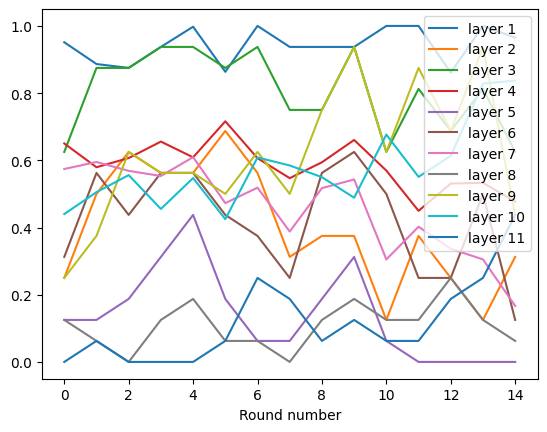

In [6]:
import matplotlib.pyplot as plt

i = 0
for frac in frac_imp.values():
    i += 1
    if i > 0:
        plt.plot(frac, label=F'layer {i}')
    else:
        continue
    if i > 10: 
        break

plt.legend()
plt.xlabel('Round number')
plt.show()

In [28]:
np.std(frac_imp[8])

0.16276687487187175

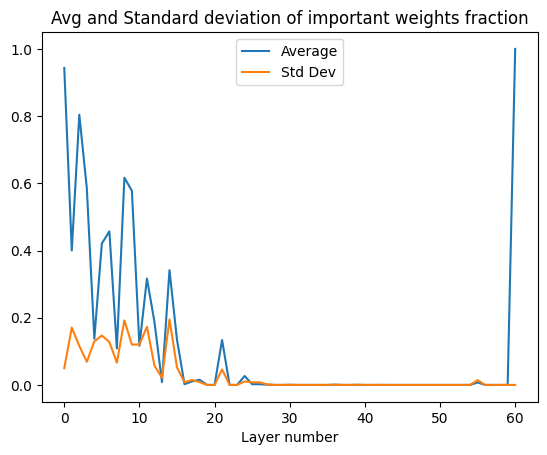

In [7]:
plt.plot([np.average(frac_imp[l]) for l in range(61)], label='Average')
plt.plot([np.std(frac_imp[l]) for l in range(61)], label='Std Dev')
plt.xlabel('Layer number')
plt.title('Avg and Standard deviation of important weights fraction')
plt.legend()
plt.show()

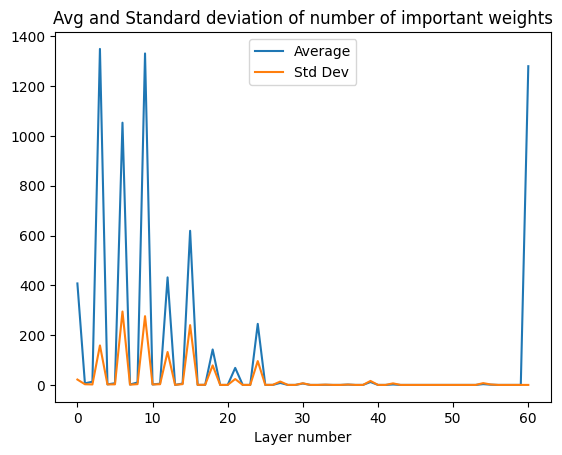

In [8]:
num_imp = {}
for layer_num, (name, param) in enumerate(model.named_parameters()):
    num_imp[name] = [len(imp_wts[rd][layer_num]) for rd in range(len(imp_wts))]

plt.plot(np.average(np.array(list(num_imp.values())), axis=1), label='Average')
plt.plot(np.std(np.array(list(num_imp.values())), axis=1), label='Std Dev')
plt.xlabel('Layer number')
plt.title('Avg and Standard deviation of number of important weights')
plt.legend()
plt.show()

In [58]:
np.around(np.average(np.array(list(num_imp.values())), axis=1), decimals=1)

array([4.0640e+02, 6.9000e+00, 1.3900e+01, 1.4777e+03, 3.0000e+00,
       8.3000e+00, 1.3141e+03, 1.6000e+00, 8.4000e+00, 1.1837e+03,
       1.4000e+00, 5.4000e+00, 5.2830e+02, 1.0000e-01, 3.1000e+00,
       3.4790e+02, 0.0000e+00, 0.0000e+00, 1.6560e+02, 0.0000e+00,
       0.0000e+00, 5.1700e+01, 0.0000e+00, 0.0000e+00, 1.8440e+02,
       0.0000e+00, 0.0000e+00, 1.1000e+01, 0.0000e+00, 0.0000e+00,
       2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 2.6000e+00, 0.0000e+00, 0.0000e+00, 4.6000e+00,
       0.0000e+00, 0.0000e+00, 6.0000e-01, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e-01, 0.0000e+00, 0.0000e+00, 1.1000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.2800e+03])

In [61]:
for k,v in num_imp.items():
    if np.average(v) >= 5:
        print(k)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer2.0.conv1.weight
layer2.0.conv2.weight
layer2.0.shortcut.0.weight
layer2.1.conv1.weight
layer2.1.conv2.weight
linear.weight


In [67]:
for name, param in model.named_parameters():
    if 'conv' not in name:
        print(name)

bn1.weight
bn1.bias
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.shortcut.0.weight
layer2.0.shortcut.1.weight
layer2.0.shortcut.1.bias
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.shortcut.0.weight
layer3.0.shortcut.1.weight
layer3.0.shortcut.1.bias
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.shortcut.0.weight
layer4.0.shortcut.1.weight
layer4.0.shortcut.1.bias
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.bn2.weight
layer4.1.bn2.bias
linear.weight


In [51]:
list(num_imp.keys())

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.shortcut.0.weight',
 'layer2.0.shortcut.1.weight',
 'layer2.0.shortcut.1.bias',
 'layer2.1.conv1.weight',
 'layer2.1.bn1.weight',
 'layer2.1.bn1.bias',
 'layer2.1.conv2.weight',
 'layer2.1.bn2.weight',
 'layer2.1.bn2.bias',
 'layer3.0.conv1.weight',
 'layer3.0.bn1.weight',
 'layer3.0.bn1.bias',
 'layer3.0.conv2.weight',
 'layer3.0.bn2.weight',
 'layer3.0.bn2.bias',
 'layer3.0.shortcut.0.weight',
 'layer3.0.shortcut.1.weight',
 'layer3.0.shortcut.1.bias',
 'layer3.1.conv1.weight',
 'layer3.1.bn1.weight',
 'l

In [47]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(i, name, param.shape)
len(np.average(np.array(list(num_imp.values())), axis=1))

61

## Minibatch class composition

In [13]:
queried_idxs = pickle.load(open("Save/Queried_idxs/" + "queried_idxs_" + filename + ".p", "rb"))
print(len(queried_idxs), type(queried_idxs[0]))
dataset = pickle.load(open("Save/Queried_idxs/" + "dataset_" + filename + ".p", "rb"))
type(dataset)

7 <class 'numpy.ndarray'>


dict

In [15]:
queried_idxs[0].shape

(1200,)

In [16]:
print(queried_idxs[0][:10])
Y_tr = dataset['Y_train']
[Y_tr[idx].item() for idx in queried_idxs[0][:10]]

[2205  612 2089 9634 4580 8578 9330  749 3628 2748]


[2, 0, 2, 9, 4, 8, 9, 0, 3, 2]

In [17]:
class_composition = [[Y_tr[idx].item() for idx in rd_idxs] for rd_idxs in queried_idxs]
print(len(class_composition), len(class_composition[0]))


7 1200


In [18]:
for rd in range(len(class_composition)):
    class_rd = [sum(np.array(class_composition[rd]) == cl) for cl in range(10)]
    print(class_rd, sum(class_rd))
# np.array(class_composition[0][:10]) == 0

[122, 104, 122, 133, 106, 106, 77, 179, 80, 171] 1200
[105, 113, 123, 125, 114, 114, 158, 111, 84, 153] 1200
[133, 137, 103, 120, 103, 107, 133, 82, 130, 152] 1200
[133, 95, 124, 145, 117, 150, 132, 100, 110, 94] 1200
[81, 198, 121, 137, 116, 118, 117, 102, 107, 103] 1200
[96, 126, 105, 113, 131, 127, 128, 128, 125, 121] 1200
[166, 64, 140, 84, 146, 113, 96, 149, 196, 46] 1200


checking class composition for BAIT

In [57]:
def find_class(idx_arr):
    return idx_arr // 2500

bait_qd_idxs = pickle.load(open("Save/Queried_idxs/" + "bait_queried_idxs_exper25K_2per" + ".p", "rb"))
len(bait_qd_idxs)

20

In [58]:
bait_class = [find_class(b) for b in bait_qd_idxs]
for b_class in bait_class:
    b_rd = [sum(b_class == cl) for cl in range(10)]
    print(b_rd, sum(b_rd))

[50, 50, 50, 750, 50, 50, 50, 50, 50, 50] 1200
[50, 50, 50, 750, 50, 50, 50, 50, 50, 50] 1200
[50, 50, 136, 562, 202, 0, 50, 50, 50, 50] 1200
[97, 50, 303, 313, 187, 50, 50, 50, 50, 50] 1200
[50, 50, 246, 36, 618, 50, 50, 0, 50, 50] 1200
[50, 50, 266, 0, 584, 50, 50, 50, 50, 50] 1200
[50, 50, 241, 0, 659, 50, 50, 50, 0, 50] 1200
[50, 50, 343, 0, 43, 514, 50, 50, 50, 50] 1200
[50, 103, 249, 0, 0, 570, 128, 50, 0, 50] 1200
[50, 240, 183, 0, 0, 577, 0, 50, 50, 50] 1200
[50, 427, 28, 0, 0, 430, 165, 50, 50, 0] 1200
[50, 349, 38, 0, 0, 0, 663, 0, 50, 50] 1200
[50, 225, 176, 0, 0, 0, 649, 50, 50, 0] 1200
[50, 250, 85, 0, 0, 0, 393, 322, 50, 50] 1200
[50, 238, 0, 0, 0, 0, 0, 862, 50, 0] 1200
[148, 177, 0, 0, 0, 0, 0, 410, 415, 50] 1200
[276, 0, 0, 0, 0, 0, 0, 273, 651, 0] 1200
[564, 0, 0, 0, 0, 0, 0, 0, 586, 50] 1200
[623, 0, 0, 0, 0, 0, 0, 0, 82, 495] 1200
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1200] 1200


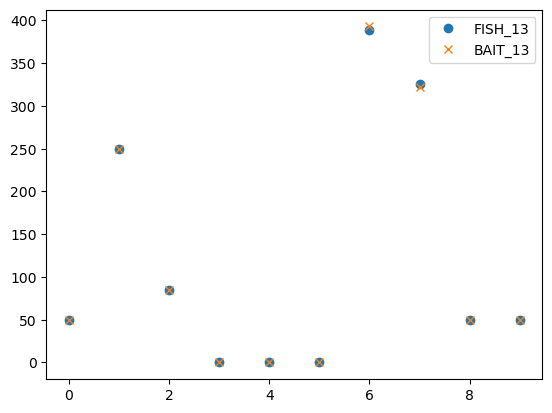

In [65]:
for rd in range(13, 14):
    plt.plot([sum(np.array(class_composition[rd]) == cl) for cl in range(10)], 'o', label=F'FISH_{rd}')
    plt.plot([sum(bait_class[rd] == cl) for cl in range(10)], 'x', label=F'BAIT_{rd}')

plt.legend()
plt.show()

# Plot of accuracy

In [5]:
import pickle
exp_savefile = "exper25K_1per_aug_chunkfix"
rd_accs = pickle.load(open("Save/Round_accuracies/Accuracy_for_" + exp_savefile + ".p", "rb"))
type(rd_accs)

dict

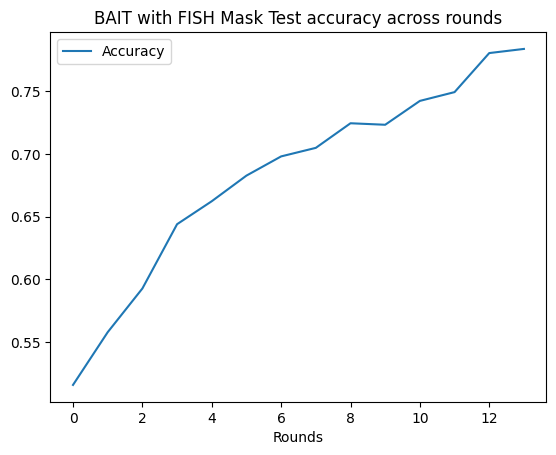

In [6]:
import matplotlib.pyplot as plt
plt.plot([rd_accs['FISH'][r] for r in range(len(rd_accs['FISH']))], label='Accuracy')
plt.xlabel('Rounds')
plt.title('BAIT with FISH Mask Test accuracy across rounds')
plt.legend()
plt.show()

In [4]:
# list(rd_accs.keys())
# len(rd_accs['FISH'])
rd_accs['FISH']

[0.516,
 0.558,
 0.5928,
 0.644,
 0.6623,
 0.6827,
 0.698,
 0.7048,
 0.7244,
 0.7232,
 0.7422,
 0.7492,
 0.7803,
 0.7836]

# Debug last-layer important weight selection issue

In [1]:
import torch
# import importlib
# ann = importlib.import_module("active-nn")

import resnet

In [2]:
import numpy as np
import pickle

imp_wts = pickle.load(open("./Save/Imp_weights/imp_wts_idxs_exper25K_1per.p", "rb"))
type(imp_wts) 

list

In [3]:
len(imp_wts)

12

In [4]:
error_rd_imp_wts = imp_wts[-1]
type(error_rd_imp_wts)

list

In [5]:
len(error_rd_imp_wts)

61

In [6]:
model = resnet.ResNet18()
filename = "exper25K_1per"
error_rd = 12
model.load_state_dict(torch.load("./Save/Models/"+ filename +"/model_" +  str(error_rd) + ".pt"))

<All keys matched successfully>

In [7]:
saved_dataset = pickle.load(open("./Save/Queried_idxs/dataset_exper25K_1per.p", "rb"))
type(saved_dataset)

dict

In [8]:
# list(saved_dataset.keys())
X_tr, Y_tr = saved_dataset['X_train'], saved_dataset['Y_train']

In [9]:
idxs_lb = pickle.load(open("./Save/Queried_idxs/queried_idxs_exper25K_1per.p", "rb"))
type(idxs_lb)

list

In [10]:
error_rd_idxs_lb = idxs_lb[-1]
type(error_rd_idxs_lb)

numpy.ndarray

In [11]:
idxs_lb_before_error = []
for idxs in idxs_lb:
    idxs_lb_before_error.extend(idxs)

len(idxs_lb_before_error)

13200

In [12]:
from torchvision import transforms
import dataset as D 
import vgg



handler = D.get_handler("CIFAR10")
args = {'n_epoch': 3, 'transform': transforms.Compose([ 
                        transforms.RandomCrop(32, padding=4),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                    ]),
                    'loader_tr_args':{'batch_size': 128, 'num_workers': 1},
                    'loader_te_args':{'batch_size': 100, 'num_workers': 1}, # change back to 1000
                    'optimizer_args':{'lr': 0.05, 'momentum': 0.3},
                    'transformTest': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])}


args['fishIdentity'] = 0
args['fishInit'] = 1
args['lamb'] = 1
args['backwardSteps'] = 0
args['pct_top'] = 0.01
args['savefile'] = "exper25K_1per"


/usr/local/home/sgchr/anaconda3/envs/pyt/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/home/sgchr/anaconda3/envs/pyt/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [13]:
# lp_grads = strategy.log_prob_grads_wrt(error_rd_imp_wts)

In [14]:
num_imp_per_layer = [len(t) for t in error_rd_imp_wts]
log_prob_grads = np.zeros((len(Y_tr), len(np.unique(Y_tr)), sum(num_imp_per_layer))) 

In [15]:
from torch.utils.data import DataLoader


masks_list = []
for layer_num, layer_wt in enumerate(list(model.parameters())):
    mask = np.zeros_like(layer_wt.detach().cpu().numpy(), dtype=bool)
    for tup in error_rd_imp_wts[layer_num]:
        mask[tup] = True
    masks_list.append(mask)

model.to('cuda')
for param in model.parameters():
    param.requires_grad = True
model.eval()
parameters = tuple(model.parameters())
    
test_loader = DataLoader(handler(X_tr, Y_tr, transform=args['transform']), shuffle=False, **args['loader_te_args']) # 'transformTest'


In [16]:
import torch.nn.functional as F


for test_batch, test_labels, idxs in test_loader:
    test_batch, test_labels = test_batch.cuda(), test_labels.cuda()
    
    outputs, e1 = model(test_batch)
    _, preds = torch.max(outputs, 1)
    probs = F.softmax(outputs, dim=1).to('cpu')
    log_probs = F.log_softmax(outputs, dim=1)
    N, C = log_probs.shape

    for n in range(N):

        for c in range(C):

            grad_list = torch.autograd.grad(log_probs[n][c], parameters, retain_graph=True) # ~0.007 secs

            
            pos = 0
            for i, grad in enumerate(grad_list):    # different layers # ~0.2 secs ~ 0.003 secs per iteration

                grad = grad.detach().cpu().numpy()  # https://discuss.pytorch.org/t/should-it-really-be-necessary-to-do-var-detach-cpu-numpy/35489
                selected_grads = grad[masks_list[i]]

                log_prob_grads[idxs[n]][c][pos:(pos+len(error_rd_imp_wts[i]))] = selected_grads
                
                pos += len(selected_grads)
            
        
        model.zero_grad()


ValueError: could not broadcast input array from shape (1280,) into shape (1285,)

In [ ]:
len(error_rd_imp_wts[60])

1285

In [ ]:
np.sum(masks_list[-1])

1280

In [18]:
sq_grads = {i: np.random.uniform(size=p.shape) for i, p in enumerate(parameters)}

In [ ]:
sq_grads[60] = 1 + sq_grads[60]

In [ ]:
sq_grads[60][3,4]

1.6184818651513364

In [21]:
def calculate_mask(sq_grads_expect, pct_top=0.02):
    list_t = list(sq_grads_expect.values())
    combined_arrays = np.hstack([t.flatten() for t in sq_grads_expect.values()]) 
    list_lengths = [len(ten.flatten()) for ten in list_t]
    cum_lengths = np.cumsum(list_lengths)
    sorted_idxs = np.argsort(combined_arrays[:cum_lengths[-2]])
    num_top = int(pct_top * len(combined_arrays))
    # top_idxs = sorted_idxs[-num_top:]

    num_last_layer = sum(list_lengths[-1:]) 
    # in FISH ResNet architecture, the last layer has bias=False
    # if last layer has both weight and bias, set -1 to -2 above

    if num_last_layer < num_top:
        top_idxs = np.hstack(
            [sorted_idxs[-(num_top - num_last_layer):], 
            np.arange(cum_lengths[-2], cum_lengths[-1])]
        )
        assert len(top_idxs) == num_top
    else:
        raise ValueError("too small top percentage")

    imp_wt_idxs = [[] for i in range(len(list_t))]
    for idx in top_idxs:
        prev_length = 0
        for idx_layer_num, length in enumerate(cum_lengths):
            if idx < length and length > prev_length: 
                # print(len_idx)
                try:
                    # s_num[len_idx].append(np.where(combined_s[idx] == list_s[len_idx])[0][0])
                    idx_tuple = np.nonzero(combined_arrays[idx] == list_t[idx_layer_num])
                    '''pass only numpy or python objects to numpy functions'''
                    # s_num[len_idx].append([idx[0] for idx in idx_tuple])
                    imp_wt_idxs[idx_layer_num].append(idx_tuple)
                except Exception:
                    print("caught error: ", idx, idx_layer_num, length, imp_wt_idxs)
                    raise
                break
            prev_length = length
    return imp_wt_idxs

test_imp_wts = calculate_mask(sq_grads, 0.01)

In [22]:
len(test_imp_wts[60])

1280

In [23]:
print([len(test_imp_wts[i]) for i in range(len(test_imp_wts))])

[0, 0, 0, 13, 0, 2, 16, 0, 0, 23, 0, 0, 33, 0, 0, 40, 0, 0, 83, 0, 1, 4, 1, 0, 67, 0, 0, 80, 0, 0, 119, 0, 2, 305, 0, 0, 10, 0, 0, 325, 0, 0, 301, 0, 1, 604, 0, 0, 1177, 1, 0, 73, 2, 1, 1204, 2, 1, 1241, 2, 0, 1280]


In [ ]:
a = np.array(([1,2],[2,3],[2,2]))
b = np.array(([2,0],[4,3],[6,2]))

In [ ]:
# c=np.hstack(a)
np.hstack(a,b)

TypeError: _vhstack_dispatcher() takes 1 positional argument but 2 were given

In [ ]:
1280*2

2560

In [ ]:
sq_grads[60].shape

(10, 128)

In [13]:
# file = open("./Save/chunksize_experiment_logs/exper1000_chunk50.log")
chunkSizes = [50, 200, 500, 1000]

for c in chunkSizes:
    with open("./Save/chunksize_experiment_logs/exper1000_chunk" + F"{c}" + ".log") as file:
        lines = file.readlines()
        num = []
        for line in lines:
            if "Select" in line: #  "Average" 
                for x, i in enumerate(line):
                    if i.isdigit():
                        num.append(float(line[x:-8]))
                        break

        print(num)

[121.82148694992065, 97.84254312515259, 78.79815292358398, 58.83225774765015, 37.62962818145752]
[120.91380023956299, 99.47865056991577, 79.06824612617493, 57.05247378349304, 37.63331174850464]
[120.10934019088745, 96.54082489013672, 76.67473888397217, 56.8214807510376, 36.6822943687439]
[116.58428907394409, 96.31320858001709, 75.56389498710632, 58.87454271316528, 37.53878450393677]


In [9]:
print(num)

[3.8848959458371004, 3.145409835378329, 2.382248107343912, 1.6275088171164194, 0.853900882601738]
